In [1]:
import MySQLdb
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import keras.backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU, TimeDistributed, Input, merge, Activation
from keras.layers import Reshape
from keras.optimizers import rmsprop, Adamax
from datetime import datetime
import time
from sklearn.preprocessing import MinMaxScaler


# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline
plt.style.use('ggplot')

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)

######################################################################################


# We'll use this to adjust for inflation to 2017 USD
filepath = "../inflation.csv"
inflation = pd.read_csv(filepath)

inflation['DATE'] = pd.to_datetime(inflation.DATE)

funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

# Make this a datetime and a little clean up
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_at'] = df_funding.funded_at.apply(lambda x: x.replace(day=1))

# Wayyyy too many funding codes. Let's put them into something a little simpler
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 
                                          'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 
                                          'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 
                                          'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 
                                          'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

# Much better. Let's get rid of this then.
del df_funding['funding_round_code']


# To be combined with a later dataframe
objects_string = """
SELECT id, normalized_name, name, category_code, status, founded_at, closed_at, 
funding_rounds, funding_total_usd FROM cb_objects
"""
df_objects = pd.read_sql(objects_string, con=conn)
df_objects['sector'] = df_objects['category_code']
del df_objects['category_code']

# Let's scale this
df_funding.raised_amount_usd /= df_funding.groupby(['funded_object_id', 
                                                    'funded_at']).raised_amount_usd.transform('count')
# To be used for timing
df_funding_timing = df_funding.merge(df_objects[['id', 'sector']], left_on='funded_object_id', right_on='id')


high_level = df_funding_timing.groupby(['funded_at']).agg({'raised_amount_usd': 'sum', 'funding_round_id': 'count'})
high_level = high_level.iloc[-108:].reset_index()
high_level.rename(columns={'funding_round_id':'number_of_investments'}, inplace=True)

adjusted_high_level = high_level.merge(inflation, left_on='funded_at', right_on='DATE')
del adjusted_high_level['DATE']

adjusted_high_level['current_USD']=adjusted_high_level.raised_amount_usd*(100/adjusted_high_level.CPIAUCSL_NBD20170101)
adjusted_high_level['USD_diff'] = adjusted_high_level.current_USD.diff()
adjusted_high_level['num_diff'] = adjusted_high_level.number_of_investments.diff()
adjusted_high_level['rolling_annual_USD'] = adjusted_high_level.current_USD.rolling(window=12).mean()

sector_group = df_funding_timing.groupby(['funded_at', 
                                          'sector']).agg({'raised_amount_usd': 'sum'}).unstack().sort_index(1,1)
sector_group.columns = sector_group.columns.to_series().map('{0[1]}'.format)
time_line = sector_group.iloc[96:]

time_series = time_line.reset_index()


time_series = time_series.apply(lambda x: x.fillna(value=0))
del time_series['funded_at']

# time_series['rolling_finance'] = time_series.finance.rolling(window=12).mean()
# time_series['expanding_software'] = time_series.software.expanding().mean()
# time_series['expanding_biotech'] = time_series.biotech.expanding().mean()
# time_series['expanding_cleantech'] = time_series.cleantech.expanding().mean()
# time_series['expanding_consulting'] = time_series.consulting.expanding().mean()
# time_series['expanding_analytics'] = time_series.analytics.expanding().mean()
# time_series['rolling_automotive'] = time_series.automotive.rolling(window=12).mean()
# time_series['rolling_transportation'] = time_series.transportation.rolling(window=12).mean()
# time_series['rolling_health'] = time_series.health.rolling(window=12).mean()
# time_series['rolling_medical'] = time_series.medical.rolling(window=12).mean()
# time_series['ticks'] = range(0,len(time_series.index.values))

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


other                  96 non-null float64

nanotech               52 non-null float64
cleantech              102 non-null float64
biotech                108 non-null float64

web                    108 non-null float64
mobile                 108 non-null float64
social                 86 non-null float64

news                   81 non-null float64
network_hosting        106 non-null float64
messaging              82 non-null float64
search                 98 non-null float64

public_relations       85 non-null float64
nonprofit              33 non-null float64
education              70 non-null float64
legal                  36 non-null float64
local                  11 non-null float64
government             5 non-null float64
security               104 non-null float64

medical                94 non-null float64
health                 65 non-null float64

hospitality            52 non-null float64
design                 26 non-null float64
photo_video            53 non-null float64
games_video            107 non-null float64
sports                 38 non-null float64
fashion                55 non-null float64
music                  72 non-null float64
pets                   15 non-null float64
travel                 73 non-null float64

manufacturing          76 non-null float64
automotive             55 non-null float64
transportation         48 non-null float64
real_estate            58 non-null float64

consulting             92 non-null float64
analytics              100 non-null float64

finance                88 non-null float64
advertising            107 non-null float64
ecommerce              105 non-null float64

software               108 non-null float64
enterprise             107 non-null float64

hardware               108 non-null float64
semiconductor          105 non-null float64

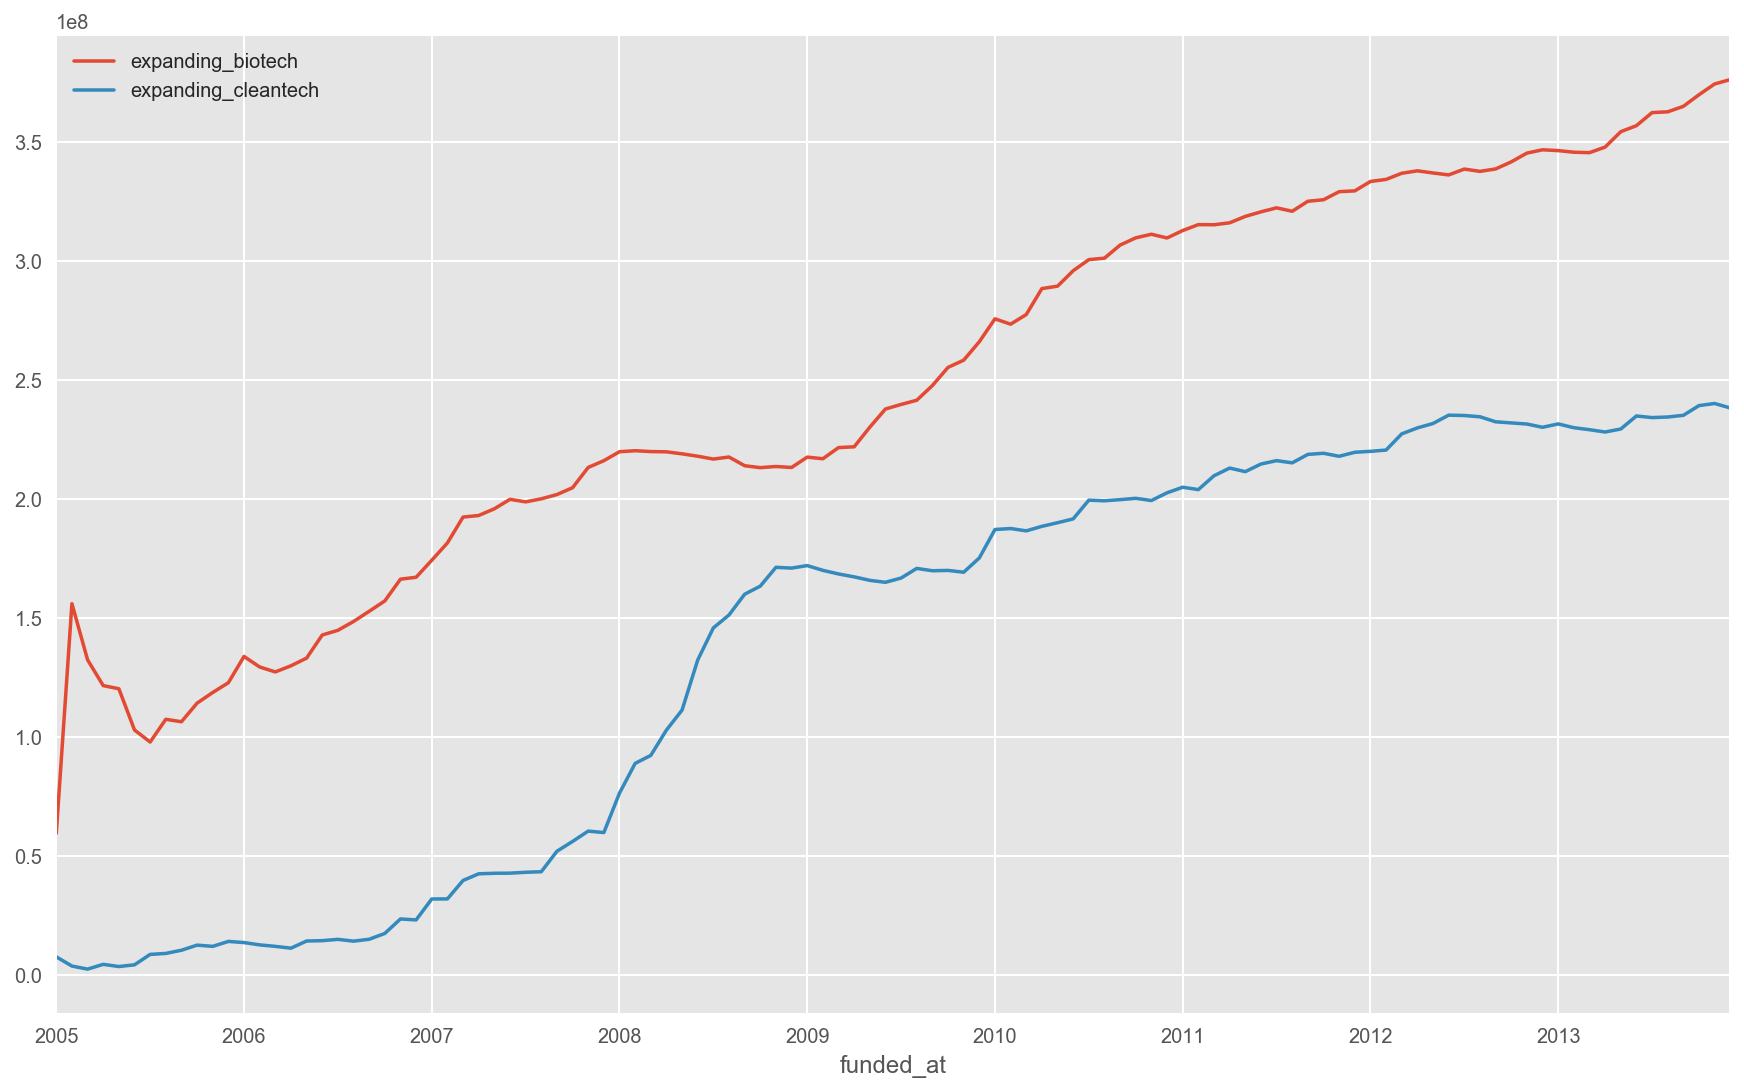

In [29]:
time_series.plot(x='funded_at', y=['expanding_biotech', 'expanding_cleantech'], figsize=(15,9))

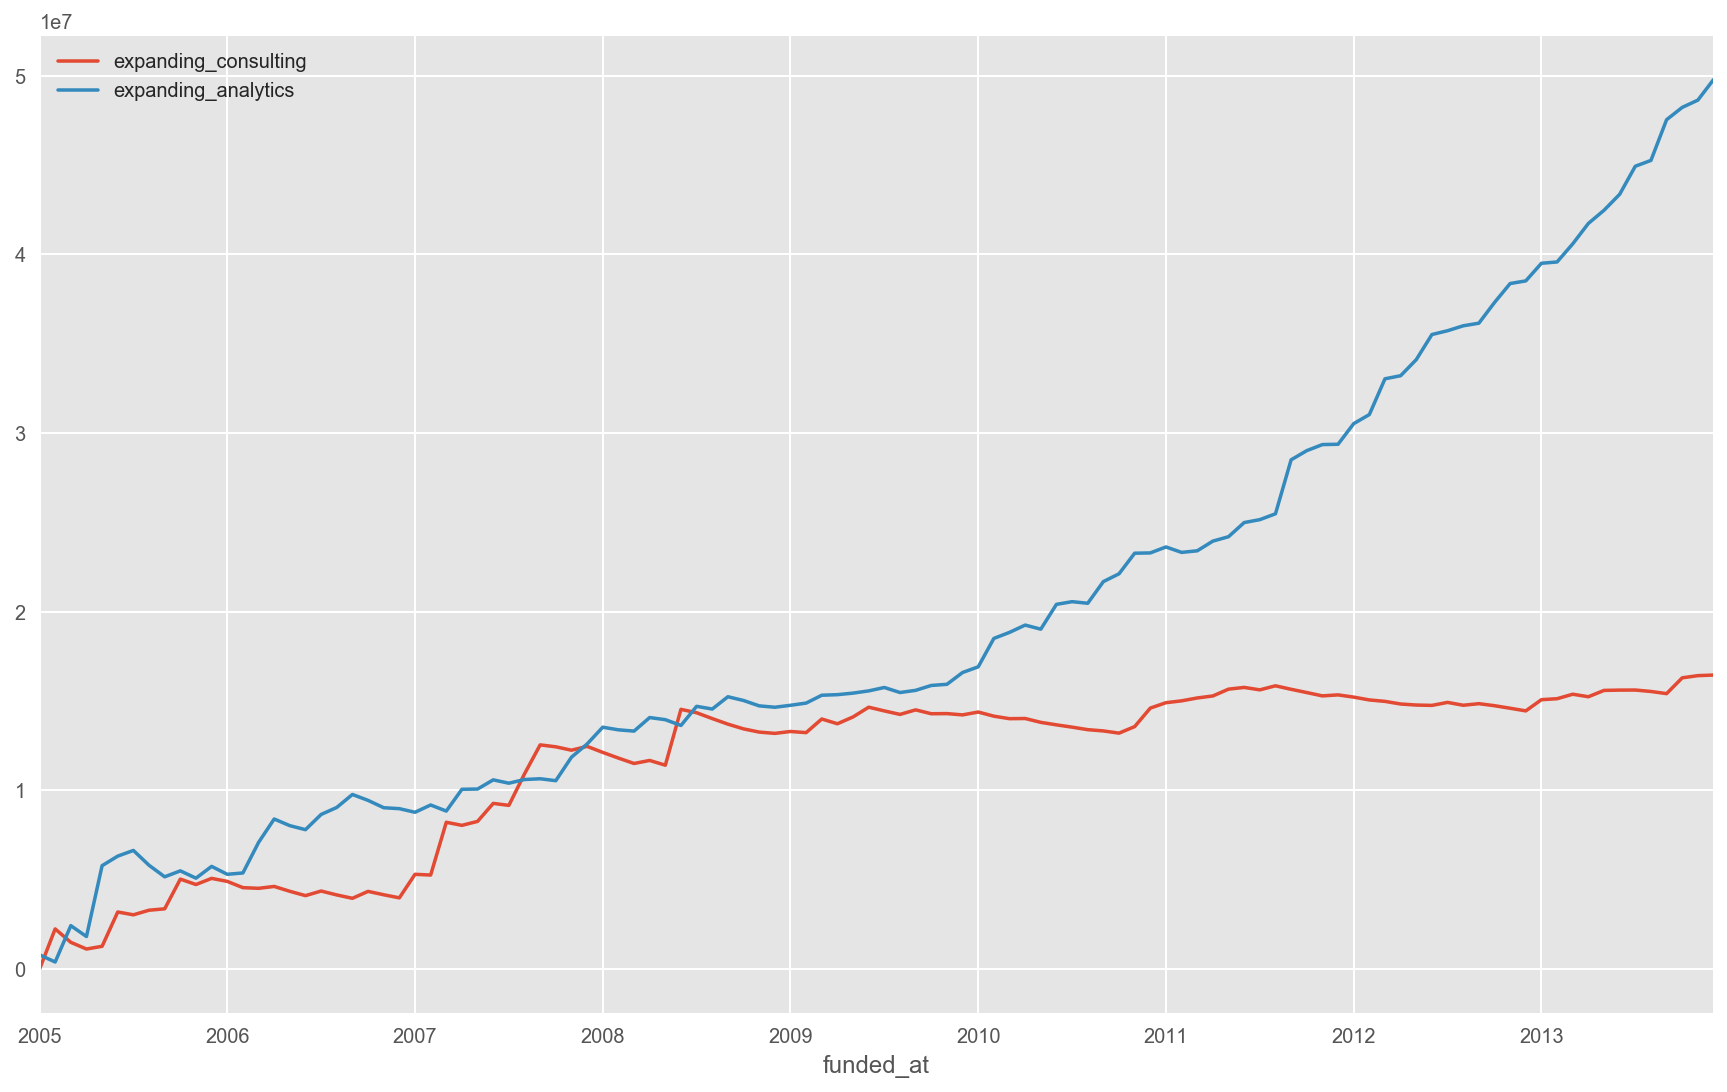

In [33]:
time_series.plot(x='funded_at', y=['expanding_consulting', 'expanding_analytics'], figsize=(15,9))

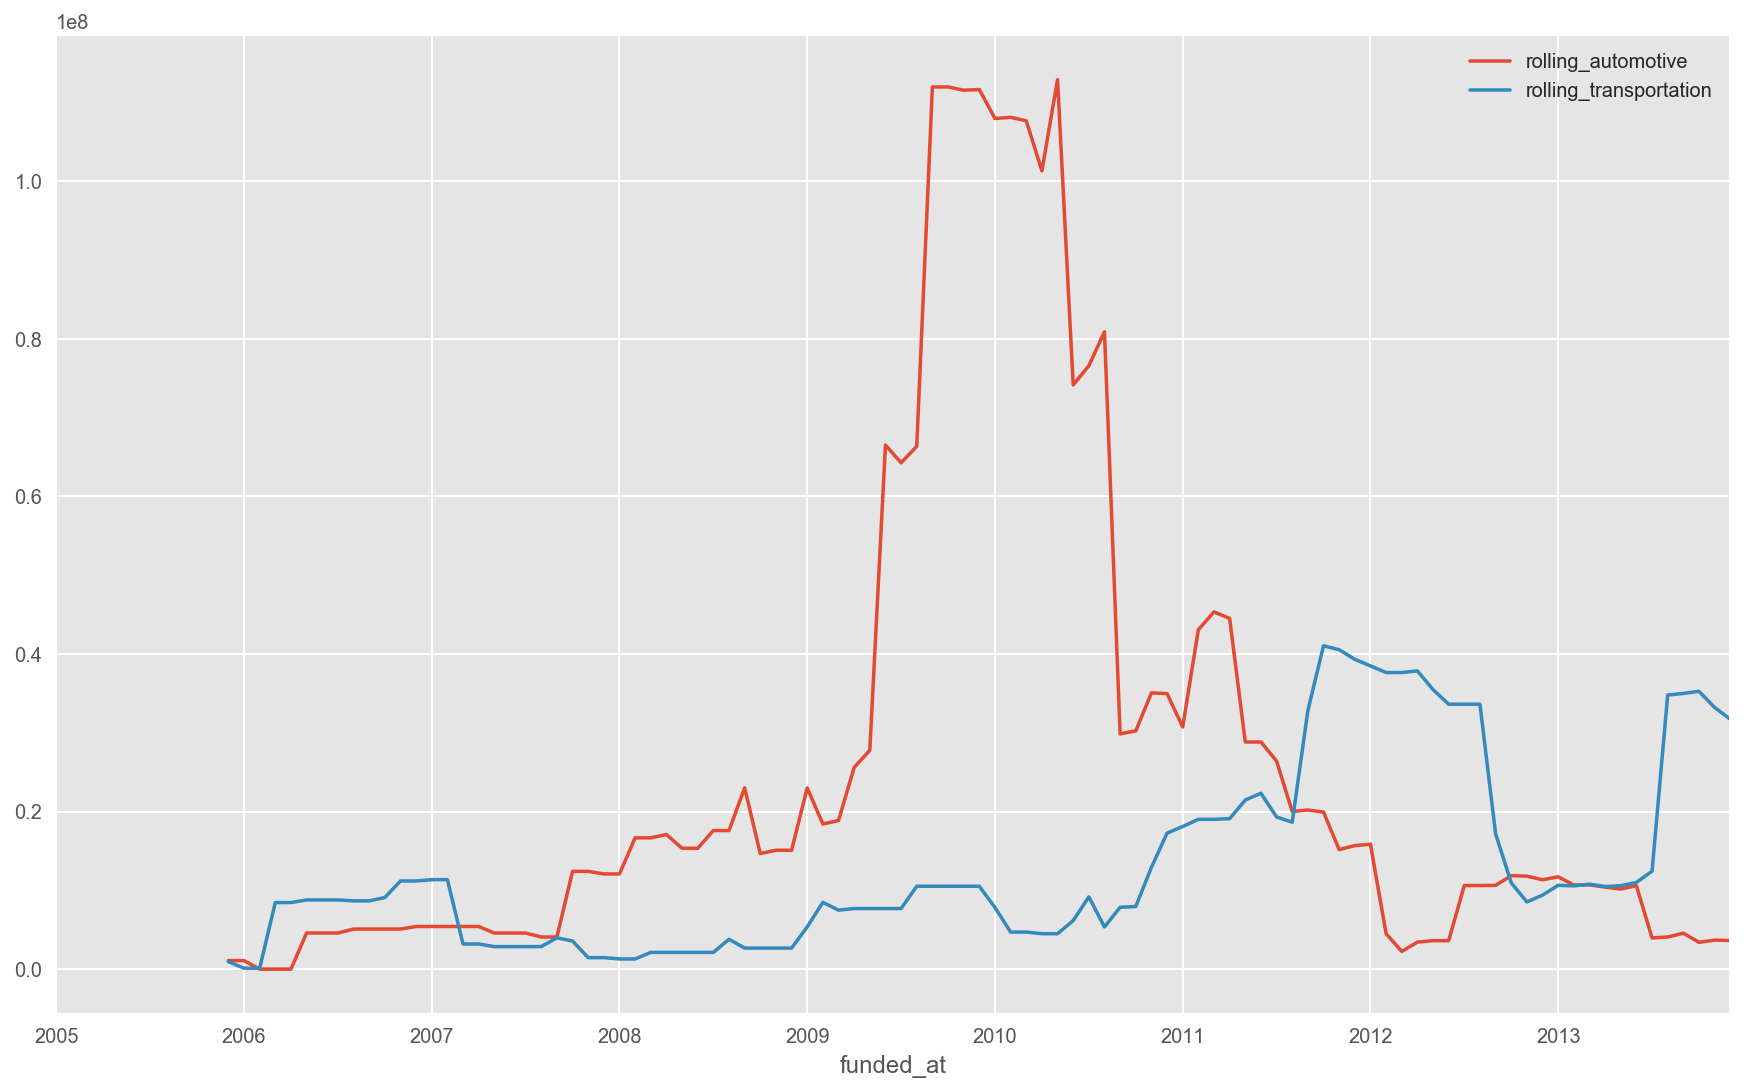

In [35]:
time_series.plot(x='funded_at', y=['rolling_automotive', 'rolling_transportation'], figsize=(15,9))

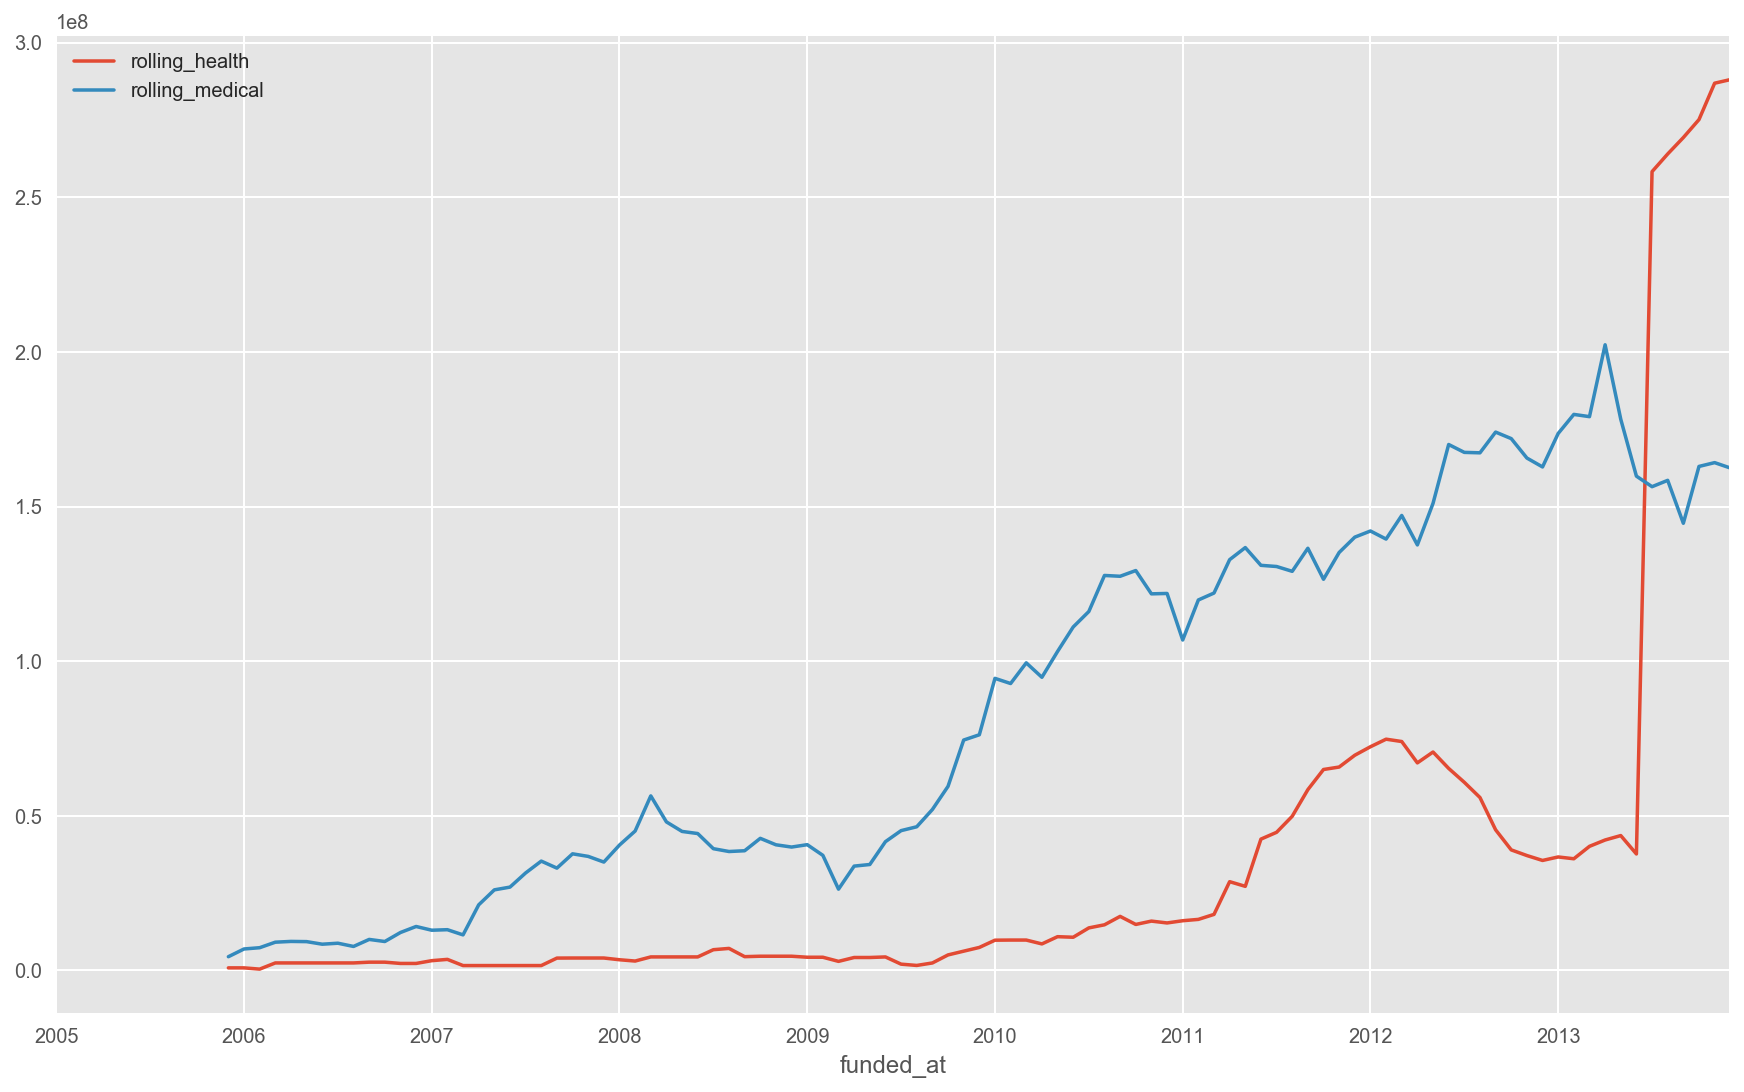

In [36]:
time_series.plot(x='funded_at', y=['rolling_health', 'rolling_medical'], figsize=(15,9))

In [11]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 42 columns):
advertising         108 non-null float64
analytics           108 non-null float64
automotive          108 non-null float64
biotech             108 non-null float64
cleantech           108 non-null float64
consulting          108 non-null float64
design              108 non-null float64
ecommerce           108 non-null float64
education           108 non-null float64
enterprise          108 non-null float64
fashion             108 non-null float64
finance             108 non-null float64
games_video         108 non-null float64
government          108 non-null float64
hardware            108 non-null float64
health              108 non-null float64
hospitality         108 non-null float64
legal               108 non-null float64
local               108 non-null float64
manufacturing       108 non-null float64
medical             108 non-null float64
messaging           108 non-null f

In [11]:
#K._BACKEND == 'tensorflow'

def custom_r2(y_true, y_pred):
    baseline = K.sum((y_true - K.mean(y_true))**2)
    model_fit = K.sum((y_true - y_pred)**2)
    return 1. - model_fit/baseline

#Scale data between 0,1 for LSTM/GRU
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
df = pd.DataFrame(MMS.fit_transform(time_series), columns=time_series.columns)
# df = pd.DataFrame(np.log1p(time_series), columns=time_series.columns)

#  Remember to shift the data so we are predicting one time step future
X = df.iloc[:-1,:]
y = df.iloc[1:,-42:] #42 sectors

train_size = .70

# Train-Test-Split-80/20
X_train, X_test = X[:int(round(len(X)*train_size, 0))], X[int(round(len(X)*train_size, 0)):]
y_train, y_test = y[:int(round(len(y)*train_size, 0))], y[int(round(len(y)*train_size, 0)):]

#Reshape for LSTM/GRU layers (** changed the Xtr on this)
Xtr = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
ytr = y_train.values.reshape((y_train.shape[0], 1, y_train.shape[1]))
Xte = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
yte = y_test.values.reshape((y_test.shape[0], 1, y_test.shape[1]))


#Check data validity
# print len(X_train) + len(X_test), len(y_train) + len(y_test)
X_train.shape[0]

75

In [3]:
def build_model(n_features, dropout, n_outputs, compile_model=1, load_weights=0, loss='mse', lr=0.01):
    '''
    Builds a n-Layer neural_network 
    
    Parmaters
    ---------
    
    '''
    model = Sequential()

    #DENSE - INPUT
    model.add(TimeDistributed(Dense(256, activation='relu'), input_shape=(None, n_features)))
    model.add(Dropout(dropout))
    
    #DENSE (2 Layers)
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))

    #LSTM (1 Layers)
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(dropout))


    #DENSE (2 Layers)
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(dropout))

#     # LSTM (1 Layer)
#     model.add(LSTM(256, return_sequences=True))
#     model.add(Dropout(dropout))

#     # DENSE (2 Layers)
#     model.add(TimeDistributed(Dense(256, activation='relu')))
#     model.add(Dropout(dropout))
#     model.add(TimeDistributed(Dense(256, activation='relu')))
#     model.add(Dropout(dropout))
    
    #OUTPUT
    model.add(TimeDistributed(Dense(n_outputs, activation='linear')))

    if compile_model == 1:
        model.compile(loss=loss, optimizer=Adamax(lr=lr), metrics=[custom_r2])

    if load_weights == 1:
        model.load_weights('/Users/anniebarry/DSI-SF-6/Capstone'+file_name+'.h5')
        
    return model
    
    
def run_neural_network(model, Xtr, ytr, Xte, yte, n_epochs, batch_size=1, verbose=0, save_weights=0):
    '''
    Runs neural_network.

    Parameters
    ----------
    '''
#     try: 
    start_time = time.time()
    print 'Executing ||', str(datetime.now()) 

    history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
              batch_size=12, verbose=verbose, nb_epoch=n_epochs, shuffle=False)

    print 'Execution_Complete || Runtime w/', n_epochs, 'epochs =', round((time.time() - start_time)/60., 2), 'minutes'

    if save_weights == 1:
        save_unit_weights()

    return history
#     except KeyboardInterrupt:
#         pass
#     except:
#         print '--Error in running model---'
    
    
def save_unit_weights():
    '''
    Saves weights of previously run neural_network.

    Parameters
    ----------
    '''
    file_name = str(datetime.now()).replace(':', '_').replace(' ','_')[:19]
    model.save_weights('/Users/anniebarry/DSI-SF-6/Capstone'+file_name+'.h5', overwrite=True)
    print 'Saved ||', str(datetime.now())
    
    
def plot_neural_net_results(history, limit_r2=0, save_results=0):
    '''
    Plots results of neural network.

    Parameters
    ----------
    '''
    results = pd.DataFrame(history.history)

    # SUMMARY RESULTS
    print '---MAX RESULTS--- \n', results[['custom_r2','val_custom_r2']].iloc[:].max(), '\n'
    print '---TAIL RESULTS--- \n', results[['custom_r2','val_custom_r2']].iloc[-1:], '\n'

    # Build figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4.5))

    # Assign Axis Plots
    ax0.plot(results[['custom_r2', 'val_custom_r2']].iloc[:])
    ax1.plot(results[['loss', 'val_loss']].iloc[:])

    # Add horizontal and vertical line for max
    ax0.axhline(results['val_custom_r2'].max(), color='red', lw=0.5)
    ax0.axvline(results['val_custom_r2'].idxmax(), color='red', lw=0.5)

    #Set axis limits
    if limit_r2 == 1:
        ax0.set_ylim(bottom=0.5, top=0.6)

    # Rename axis titles
    ax0.set_title('r2', fontsize=15)
    ax1.set_title('loss', fontsize=15)

    #ax0.legend(loc='lower right')

    # Show plots
    plt.show()

    if save_results == 1:
        file_name = str(datetime.now()).replace(':', '_').replace(' ','_')[:19]
        results.to_csv('/Users/anniebarry/DSI-SF-6/Capstone'+ file_name + '.csv')


In [12]:
#1 - Build that Model
model = build_model(n_features=Xtr.shape[2], dropout=0.5, n_outputs=42, compile_model=1, load_weights=0, lr=0.0005)

#2 - Run Model ()
history = run_neural_network(model=model, Xtr=Xtr, ytr=ytr, Xte=Xte, yte=yte, save_weights=0, verbose=1, n_epochs=1000)

Executing || 2017-05-31 16:00:55.600092
Train on 75 samples, validate on 32 samples
Epoch 1/1000
75/75 [==============================] - 1s - loss: 0.0241 - custom_r2: -0.2751 - val_loss: 0.0683 - val_custom_r2: -0.4493
Epoch 2/1000
75/75 [==============================] - 0s - loss: 0.0227 - custom_r2: -0.1815 - val_loss: 0.0663 - val_custom_r2: -0.4043
Epoch 3/1000
75/75 [==============================] - 0s - loss: 0.0216 - custom_r2: -0.1197 - val_loss: 0.0644 - val_custom_r2: -0.3611

---MAX RESULTS--- 
custom_r2        0.395655
val_custom_r2    0.109546
dtype: float64 

---TAIL RESULTS--- 
     custom_r2  val_custom_r2
999   0.382023       0.106916 



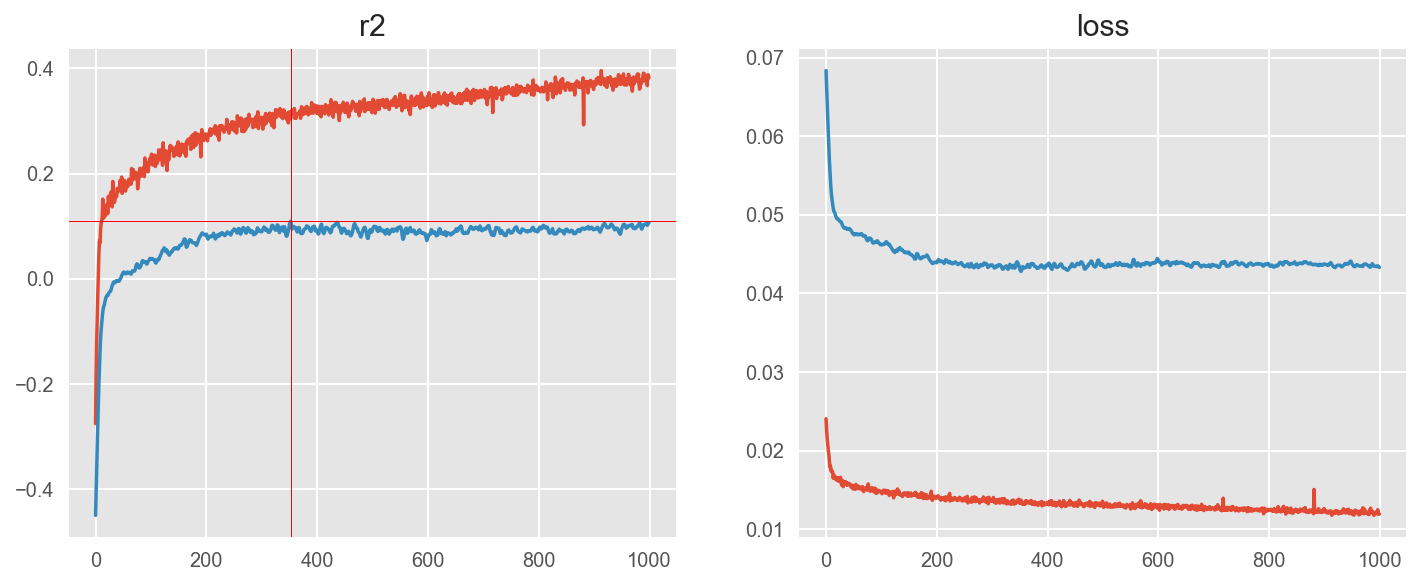

In [13]:
#3 - Plot Model
plot_neural_net_results(history, save_results=0)

In [29]:
predictions = model.predict(Xte)
predictions = pd.DataFrame(predictions.reshape(predictions.shape[0], predictions.shape[2]))

In [30]:
predictions

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.305896,0.121721,0.032177,0.392150,0.403991,0.148095,0.006829,0.155683,0.017373,0.239526,...,0.073479,0.033724,0.065356,0.172732,0.060283,0.217708,0.062296,0.025992,0.053818,0.148996
1,0.273963,0.122318,0.047164,0.403550,0.367142,0.121523,0.003481,0.157389,0.015632,0.250245,...,0.064453,0.034840,0.073886,0.175131,0.045917,0.199295,0.059568,0.028036,0.055757,0.134087
2,0.289102,0.120608,0.040294,0.403855,0.386685,0.130319,0.004071,0.162462,0.016188,0.246870,...,0.067873,0.033511,0.072667,0.175958,0.052062,0.207982,0.062481,0.028153,0.056490,0.140121
3,0.203573,0.087122,0.038978,0.304046,0.243884,0.108621,0.004574,0.089056,0.011564,0.171243,...,0.051398,0.036789,0.063111,0.155844,0.029844,0.220355,0.043996,0.025596,0.044269,0.114150
4,0.283955,0.102995,0.031339,0.339548,0.348803,0.161016,0.009399,0.111348,0.012798,0.203163,...,0.068896,0.032850,0.061462,0.156158,0.062900,0.231726,0.048421,0.025477,0.042750,0.144471
5,0.275704,0.108069,0.034247,0.349785,0.348808,0.145646,0.007757,0.127681,0.014679,0.208771,...,0.063886,0.032886,0.063032,0.160299,0.054051,0.223691,0.055806,0.025070,0.046458,0.139230
6,0.164921,0.078425,0.043783,0.270601,0.183579,0.089239,0.003568,0.078600,0.008653,0.150141,...,0.036410,0.036099,0.062496,0.150520,0.017844,0.219267,0.036477,0.023799,0.045326,0.102761
7,0.279695,0.119208,0.045154,0.406238,0.370959,0.124194,0.000574,0.143992,0.017988,0.245949,...,0.074719,0.036101,0.076792,0.183311,0.044497,0.204142,0.059953,0.026597,0.051162,0.130944
8,0.227243,0.100113,0.041060,0.329797,0.281673,0.110271,0.004206,0.111976,0.013689,0.192092,...,0.053126,0.036025,0.065977,0.160334,0.035099,0.211003,0.051810,0.025237,0.048807,0.119473
9,0.287928,0.115948,0.035482,0.394400,0.376117,0.135306,0.001444,0.132395,0.019166,0.232946,...,0.075432,0.037577,0.071934,0.181097,0.048978,0.216612,0.059856,0.027042,0.047768,0.136571


In [32]:
MMS.data_min_.shape


(42,)

In [34]:
def inverse_transform(x):
    lst = []
    counter = 0
    for i in x:
        i -= MMS.data_min_[0 + counter]
        i /= MMS.scale_[0 + counter]
        lst.append(int(i))
        #print counter
        if counter != 42:
            counter += 1
        else:
            counter = 0
            
    return lst

predictions = predictions.apply(inverse_transform)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,140474427,55896847,14776196,180083845,185521467,68008432,3135905,71492975,7978247,109995643,...,33743035,15486697,30012734,79322233,27683497,99976405,28607796,11936308,24714565,68422239
1,77928468,34793200,13415682,114789129,104433168,34567083,990224,44769127,4446531,71181705,...,18333569,9910277,21016754,49815782,13061063,56689306,16944062,7974898,15859865,38140934
2,177075241,73872145,24679832,247361422,236844479,79820332,2493640,99507707,9915418,151207827,...,41572099,20525718,44508374,107774005,31887802,127389214,38269453,17243833,34600221,85824184
3,-16205805774377144,-16205805889114490,-16205805936549804,-16205805675382850,-16205805734659802,-16205805867932166,-16205805970447720,-16205805887208912,-16205805963561214,-16205805806231748,...,-16205805924312842,-16205805938706596,-16205805912771844,-16205805821403866,-16205805945549686,-16205805757841874,-16205805931606068,-16205805949734750,-16205805931336672,-16205805862484252
4,282265756,102382656,31152145,337528312,346727959,160058506,9343398,110685234,12721972,201954413,...,68485819,32654621,61096744,155228910,62525583,230348018,48133377,25325435,42496080,143611799


In [ ]:
#1 - Build that Model
model = build_model(n_features=Xtr.shape[2], dropout=0.5, n_outputs=42, compile_model=1, load_weights=0, lr=0.0005)

#2 - Run Model ()
history = run_neural_network(model=model, Xtr=Xtr, ytr=ytr, Xte=Xte, yte=yte, save_weights=0, verbose=1, n_epochs=500)

#3 - Plot Model
plot_neural_net_results(history, save_results=0)